In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # calculate distance matrix
from scipy.linalg import lu # calculate LU decomposition
from scipy.optimize import minimize # minimization of scalar function
from itertools import combinations

# 1. Generate $Y$

## 1-1. Distance matrix

 $ d_{ij} = ||X_i - X_j||$

In [103]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):
  x_coords = np.random.normal(xmu, xsd, size=N_points)
  y_coords = np.random.normal(ymu, ysd, size=N_points)
  coords = np.column_stack((x_coords, y_coords))

  return coords

In [104]:
# function that calculates distances between coordinates
def distances(coords):
  distances = cdist(coords, coords, metric='Euclidean')

  return distances

In [105]:
np.random.seed(24)

In [106]:
# set parameters
p = 1000 # dimensionaltiy

In [107]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)

In [108]:
# get distance matrix
d = distances(X)
d.shape

(1000, 1000)

## 1-2. Covariance Matrix $\Sigma$
$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) $

In [109]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [110]:
# set parameter for Sigma
paramTrue = [1, 1/2]
SigmaTrue = Sigma(paramTrue, d)

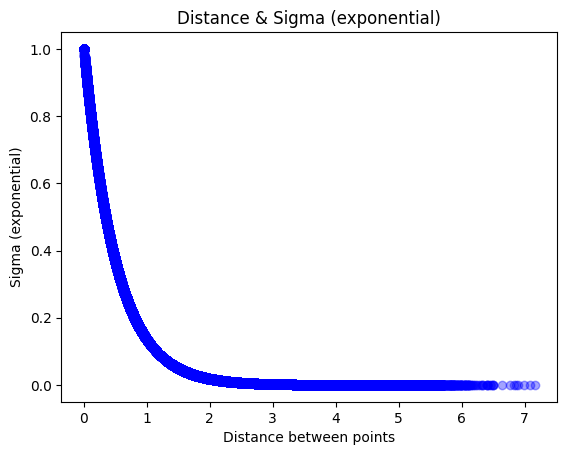

In [111]:
# plotting
d_plot = d.reshape((p*p,))
Sigma_plot = SigmaTrue.reshape((p*p,))
data = pd.DataFrame({'Distances': d_plot, 'Sigma(exp)': Sigma_plot})

plt.scatter(data['Distances'], data['Sigma(exp)'], c='blue', alpha=0.2)
plt.ylabel('Sigma (exponential)')
plt.xlabel('Distance between points')
plt.title('Distance & Sigma (exponential)')
plt.show()

# 1-3. Generate data $Y$
* $ Y = \Sigma^{1/2} \cdot U $
  * $\Sigma$ is positive semi definite
  * $U \sim N(0, I_p)$

* Dataframe of $Y$ ; N $\times$ p
  * Size: N = 1000
  * Dimensionality: p = 1000







In [112]:
# get sigmahalf
## cf. check if SigmaTrue is positive definite
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue)
    print('Covariance matrix is positive definite')
else:
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [113]:
import pandas as pd

In [114]:
N = 1000 # size

results = []

for i in range(N):
  U = np.random.normal(0, 1, p).reshape(p, 1)
  results.append(np.dot(SigmaHalf, U))

col_names = ['y{}'.format(i+1) for i in range(p)]
y_df = pd.DataFrame(np.reshape(results, (N, p)), columns=col_names)

# 2. Calculated Covariance


In [115]:
cov = np.cov(y_df.T) # cf. np.cov; each row represents variavble, each column a single observation
cov.shape

(1000, 1000)

In [116]:
# make matrix into array
d_plot = d.reshape((p*p,)) 
cov_plot = cov.reshape((p*p, ))

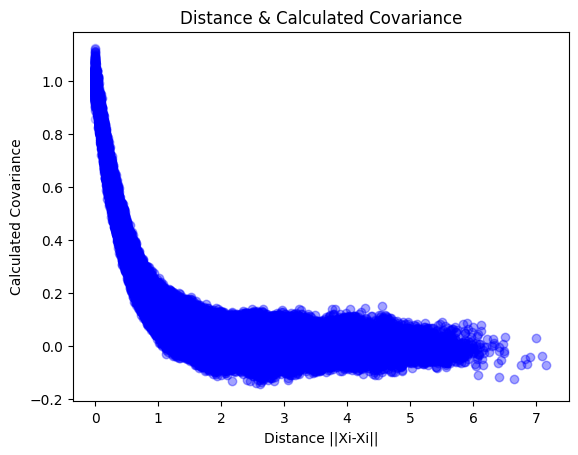

In [117]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.show()

# 3. Regression
$ Cov(y_i, y_j|X) = E[y_i*y_j|X] = ?$

where $ X = ||xi-xj||$

In [118]:
from scipy.optimize import curve_fit

## 3-1. $ Cov(yi, yj|X) $
* Assume exponential covariance model.
* The model follows $ Cov(yi, yj|X) = \theta_1 exp(-\theta_2 X)$

In [119]:
# define the exponential function
def exp_func(dis, theta1, theta2):
    return theta1*np.exp(-theta2*dis)

In [120]:
# perform exponential regression
params, param_cov = curve_fit(exp_func, d_plot, cov_plot)

theta1, theta2 = params

# generate fitted curve
x_fit = np.linspace(min(d_plot), max(d_plot), 100)
y_fit = exp_func(x_fit, theta1, theta2)

fit = 'Fitted curve: {} * exp(-{} * X)'.format(round(theta1,4), round(theta2,4))
print(fit)

Fitted curve: 0.9888 * exp(-2.0113 * X)


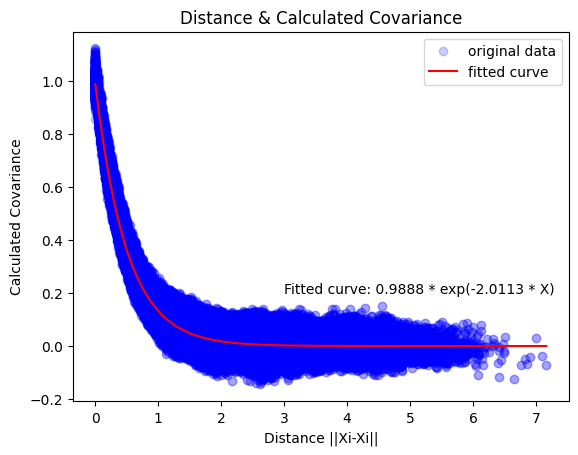

In [121]:
# exponential regression
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2, label='original data')
plt.plot(x_fit, y_fit, c='red', label='fitted curve')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')

plt.title('Distance & Calculated Covariance')
plt.legend()
plt.text(3.0, 0.2, fit)
plt.show()

## 3-2. Try log transformation
* $ log(Cov(yi, yj|X)) = log(\theta_1) -\theta_2 X $

In [122]:
def logged_func(dis, theta1, theta2):
    return np.log(theta1) - theta2 * dis

In [123]:
cov_plot_modified = cov_plot + 0.2
log_plot = []

for i in range(len(cov_plot_modified)):
    if cov_plot_modified[i] != 0:
        log_plot.append(np.log(cov_plot_modified[i]))
        
    else:
        offset = 1e-10
        log_plot.append(np.log(cov_plot_modified[i] + offset))

In [124]:
# linear regression
params, param_cov = curve_fit(logged_func, d_plot, log_plot)
theta1, theta2 = params

# generate fitted line
x_fit = np.linspace(min(d_plot), max(d_plot), 100)
y_fit = logged_func(x_fit, theta1, theta2)

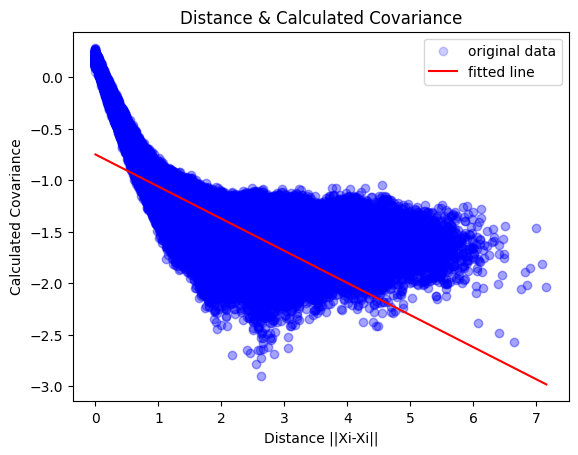

In [125]:
# linear regression
plt.scatter(d_plot, log_plot, c='blue', alpha=0.2, label='original data')
plt.plot(x_fit, y_fit, c='red', label='fitted line')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')

plt.title('Distance & Calculated Covariance')
plt.legend()
plt.show()

## 3-3. $E[y_i*y_j|X]$


In [126]:
# get combinations of yi*yj (i =/= j)
column_pairs = list(combinations(col_names, 2))

In [127]:
# distances referring to column_pairs
distances = pd.DataFrame(d, index=col_names, columns=col_names)
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]

In [128]:
# yi*yj pairs
y1 = y_df.loc[0,:]

product_pairs = []
index_names = []

for i in range(1, N):
    for j in range(i+1, N+1):
        product_pairs.append(y1['y{}'.format(i)]*y1['y{}'.format(j)])
        index_names.append('y{}*y{}'.format(i,j))

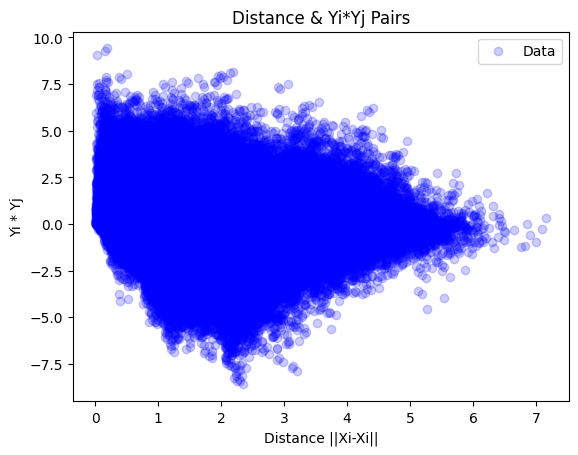

In [129]:
# plotting pairs data
plt.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2, label='Data')
plt.xlabel('Distance ||Xi-Xi||')
plt.ylabel('Yi * Yj')
plt.title('Distance & Yi*Yj Pairs')
plt.legend()
plt.show()

In [130]:
# perform exponential regression
params, param_cov = curve_fit(exp_func, dis_pairs, product_pairs)

theta1, theta2 = params

x_fit = np.linspace(min(dis_pairs), max(dis_pairs), 100)
y_fit = exp_func(x_fit, theta1, theta2)

fit = 'Fitted curve: {} * exp(-{} * X)'.format(round(theta1,4), round(theta2,4))
print(fit)

Fitted curve: 1.5584 * exp(-2.0381 * X)


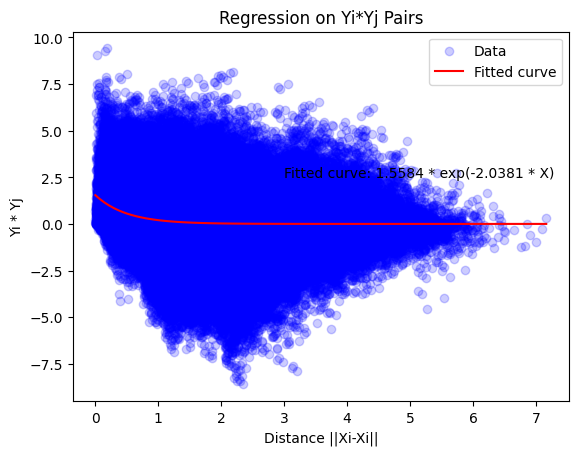

In [131]:
# plotting exponential regression of product pairs
plt.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2, label='Data')
plt.plot(x_fit, y_fit, c='red', label='Fitted curve')
plt.xlabel('Distance ||Xi-Xi||')
plt.ylabel('Yi * Yj')
plt.title('Regression on Yi*Yj Pairs')
plt.text(3.0, 2.5, fit)
plt.legend()
plt.show()